# Troubled Loan Detection with [Machine Learning](#https://en.wikipedia.org/wiki/Machine_learning)

<a id='introduction'></a>
## Introduction##
This [Jupyter notebook](https://jupyter.org/) is an example of how "Machine Learning" can analyze features and labels of a training set to try to "learn" a set of weights for being able to "predict" the labels in additional data that was not used during training. For machine learning to work, we are making some important assumptions that may not be true for every use case.  In particular, we are hypothesizing (a) that the outputs <i>can</i> be predicted from the inputs, and (b) that the available data is sufficiently informative to learn the relationship between the inputs and outputs.  These two assumptions largely depend on the input features we select and the amount of representational data we can collect.

For this particular example we will examine over 30 loan features on roughly 75,000 loans that have all been labeled as 1 ("bad") or 0 ("good"), based on whether or not they were charged off within six months of the date the data was examined.  The methods used employ the [sklearn](https://en.wikipedia.org/wiki/Scikit-learn) library for [Python](https://en.wikipedia.org/wiki/Python_(programming_language)).  This is an example of [supervised learning](https://en.wikipedia.org/wiki/Supervised_learning) (we provide the "ground truth" labels for the training data), using various models. A separate notebook took the approach of "Deep Learning" with an artificial neural network. In this notebook, we will instead compare the performance of Logistic Regression, Decision Tree, K-Nearest Neighbors, Support Vector Machine (SVM), and Random Forest.  We will make use of many recent, advanced techniques in machine learning that the sklearn framework readily exposes, such as...


<a id='imports'></a>
## Import Necessary Packages ##

First, let's run the cell below (put your cursor in the cell and press Shift-Enter) to import all the packages that you will need.
- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python. 
- [pandas](https://pandas.pydata.org/) is a data analysis library.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [seaborn](https://seaborn.pydata.org/) is a data visualization library based on matplotlib.
- [scikitplot](https://anaconda.org/conda-forge/scikit-plot) is yet another plotting library.
- [sklearn](https://scikit-learn.org/stable/) is a collection of algorithms for classification, regression, and clustering.
- [keras](https://pypi.org/project/Keras/) is a high level neural network library for deep learning applications.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

# Set global fiugure properties
import matplotlib as mpl
mpl.rcParams.update({'axes.titlesize' : 20,
                     'axes.labelsize' : 18,
                     'legend.fontsize': 16})

# Set default seaborn plotting style
sns.set_style('white')

In [12]:
%pip install skikit-plot==0.3.7

ERROR: Could not find a version that satisfies the requirement skikit-plot==0.3.7 (from versions: none)
ERROR: No matching distribution found for skikit-plot==0.3.7


Following cell is only run if you are running the notebook on Google Colab. These lines delete files and folders if they exist and then load and unzip a file from GitHub repository. This is done because files on Colab do not persist indefinitely. Do not run the next cell if you are running the notebook in your own Jupyter server on your laptop.

In [50]:
!rm -f datasets/*
!rmdir datasets
#!rm -f helper_code/__pycache__/*
#!rmdir helper_code/__pycache__
!rm -f helper_code/*
!rmdir helper_code
!rm -f models/*
!rmdir models

# Extra imports for pulling zip file from Carl GitHub repository.
from datetime import datetime
import requests, zipfile, io

r = requests.get( 'https://raw.github.com/cbarlow-corelationinc/troubled_loan_detection/main/TroubledLoanDetectionFiles.zip')
r.status_code
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()
!ls -Abl 

total 36
-rw-r--r-- 1 root root 10948 Feb  4 16:37 cb3_ann_utils.py
-rw-r--r-- 1 root root  2646 Feb  4 16:37 cb3_email_util.py
drwxr-xr-x 1 root root  4096 Feb  3 15:19 .config
drwxr-xr-x 2 root root  4096 Feb  4 16:37 datasets
drwxr-xr-x 2 root root  4096 Feb  4 16:37 helper_code
drwxr-xr-x 2 root root  4096 Feb  4 16:37 models
drwxr-xr-x 1 root root  4096 Feb  1 17:27 sample_data


And some additional imports we will need for these models and metrics.

In [45]:
import patsy as pts
import scikitplot as skplt
import tensorflow.python.util.deprecation as deprecation

from datetime import datetime
from math import log10
from pandas.api.types import CategoricalDtype
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

# Import tools needed for visualization
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydot

# Helper code to plot confusion matrix
from helper_code import mlplots as ml

from cb3_ann_utils import describe_datasets, build_compile_fit_model, \
    my_f1_score, cb3_calculateResults1, cb3_calculateResults2, cb3_displayResults
from cb3_email_util import email_result, email_completion_notice

sns.set(style='white', context='notebook', palette='deep')
deprecation._PRINT_DEPRECATION_WARNINGS = False
%matplotlib inline

np.random.seed(33)    # in case you need to be able to duplicate exact shuffling of data
print("Done importing required modules.")

ModuleNotFoundError: ignored

Return to [top](#introduction)
<a id='load_data'></a>
## Load the Data
The Pandas library has a read_csv() function that can read a CSV file directly into a Pandas DataFrame. This is particularly easy if the first row of the CSV file has labels and if those labels do not contain spaces. We can even specify a column that will act as an index and not as a normal column, as seen here with the LOAN_SERIAL column.

In [ ]:
# Read CSV data
loan_data = pd.read_csv('datasets/AnonymousLoans20190930OregonStateFull.csv', index_col = 'LOAN_SERIAL')
loan_data.head()

,LN_TYPE_CATEGORY,CREDIT_LIMIT,COBORROWER_COUNT,ORIGINAL_TERM_IN_MONTHS,BALANCE,MONTHLY_PMT,INTEREST_RATE,DQ_DAYS,STILL_MISSED_FIRST_PMT,HAS_COLLATERAL,...,LR_AMOUNT,SCORE,AGE_OF_SCORE,AGGR_SHARE_COUNT,AGGR_SHARE_BAL,DD_CHANGE,CREDIT_LIMIT_INCREASE_COUNT,OFF_AUTO_PAY_COUNT,CHARGE_OFF_DATE,BINARY_STATUS
LOAN_SERIAL,,,,,,,,,,,,,,,,,,,,,
42558,CE,0.00,0,74,6003.52,200.41,2.59,0,0,1,...,0.0,218,171,4,260.01,1769.83,0,0,NaN,0
42601,CC,15000.00,0,0,48.04,25.00,9.75,0,0,0,...,0.0,0,0,2,15717.72,36238.45,0,0,NaN,0
37695,CE,0.00,0,73,8889.52,211.55,5.09,0,0,1,...,0.0,0,0,2,133.08,0.00,0,0,NaN,0
38623,LC,5000.00,0,0,0.00,0.00,9.00,0,0,0,...,0.0,0,0,5,4841.67,-2426.46,0,0,NaN,0
124753,CE,33719.32,1,85,28356.22,465.44,3.99,0,0,1,...,0.0,229,487,2,21170.88,1023.90,0,0,NaN,0


<a id='explore_data'></a>
## Exploratory Data Analysis (EDA) (Optional) ##
Now you can optionally display additional information about the data, such as the keys/feature column names, how many non-null values there are for each, and the data type (float64):

In [ ]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75271 entries, 42558 to 109035
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   LN_TYPE_CATEGORY             75271 non-null  object 
 1   CREDIT_LIMIT                 75271 non-null  float64
 2   COBORROWER_COUNT             75271 non-null  int64  
 3   ORIGINAL_TERM_IN_MONTHS      75271 non-null  int64  
 4   BALANCE                      75271 non-null  float64
 5   MONTHLY_PMT                  75271 non-null  float64
 6   INTEREST_RATE                75271 non-null  float64
 7   DQ_DAYS                      75271 non-null  int64  
 8   STILL_MISSED_FIRST_PMT       75271 non-null  int64  
 9   HAS_COLLATERAL               75271 non-null  int64  
 10  AGE_IN_DAYS                  75271 non-null  int64  
 11  MEMBERSHIP_DAYS              75271 non-null  int64  
 12  PMT_COUNT_MADE               75271 non-null  int64  
 13  PMT_COUNT_D

Now do a label encoding on the categorical feature LN_TYPE_CATEGORY and split the dataframe into loan_features and loan_label, where the label comes from the BINARY_STATUS column, where 1 indicates a loan that gets charged off in next six months and 0 inidicates the majority case where the loan is <i>not</i> charged off in the next six months.

In [ ]:
# Generate categorical features
categorical_features = loan_data[['LN_TYPE_CATEGORY']]

# Encocde categorical features
categorical_features = categorical_features.apply(LabelEncoder().fit_transform)

# Extract numerical features
#numerical_features = loan_data[['CREDIT_LIMIT', 'COBORROWER_COUNT', 'ORIGINAL_TERM_IN_MONTHS', 'BALANCE', 'MONTHLY_PMT', 'INTEREST_RATE', \
#                               'DQ_DAYS', 'STILL_MISSED_FIRST_PMT', 'HAS_COLLATERAL', 'AGE_IN_DAYS', 'MEMBERSHIP_DAYS', 'PMT_COUNT_MADE', \
#                               'PMT_COUNT_DQ_30_TO_59', 'PMT_COUNT_DQ_60_TO_89', 'PMT_COUNT_DQ_90_TO_119', \
#                               'PMT_COUNT_DQ_120_AND_UP', 'MONTHLY_INCOME', 'MONTHLY_EXPENSE', 'LR_AMOUNT', 'SCORE', 'AGE_OF_SCORE', \
#                               'AGGR_SHARE_COUNT', 'AGGR_SHARE_BAL', 'DD_CHANGE', 'CREDIT_LIMIT_INCREASE_COUNT', 'OFF_AUTO_PAY_COUNT']]
# using only 11 of original 30 features
numerical_features = loan_data[['DQ_DAYS', 'AGGR_SHARE_BAL', 'PMT_COUNT_MADE', 'MONTHLY_PMT', 'PMT_COUNT_DQ_30_TO_59', \
                                'CREDIT_LIMIT', 'INTEREST_RATE', 'PMT_COUNT_DQ_90_TO_119', 'SCORE', \
                                'COBORROWER_COUNT', 'MONTHLY_EXPENSE']]
#loan_features = pd.concat([categorical_features, numerical_features], axis=1)
loan_features = numerical_features

loan_labels = loan_data['BINARY_STATUS']
loan_features.head()

,DQ_DAYS,AGGR_SHARE_BAL,PMT_COUNT_MADE,MONTHLY_PMT,PMT_COUNT_DQ_30_TO_59,CREDIT_LIMIT,INTEREST_RATE,PMT_COUNT_DQ_90_TO_119,SCORE,COBORROWER_COUNT,MONTHLY_EXPENSE
LOAN_SERIAL,,,,,,,,,,,
42558,0,260.01,24,200.41,0,0.00,2.59,0,218,0,0.0
42601,0,15717.72,24,25.00,0,15000.00,9.75,0,0,0,0.0
37695,0,133.08,25,211.55,2,0.00,5.09,0,0,0,0.0
38623,0,4841.67,1,0.00,0,5000.00,9.00,0,0,0,0.0
124753,0,21170.88,15,465.44,0,33719.32,3.99,0,229,1,0.0


Models like Decision Tree and Random Forest do not require scaling/normalization of features and only require label encoding of categorical features rather than one-hot encoding. But Logistic Regression, KNN, SVM, ANN, K-Means, PCA, etc. all require scaling of features, so let's prepare a version of loan_features that works for these models as well.

In [ ]:
# Scale features and then perform variance thresholding
#split to training and testing
features_train, features_test, labels_train, labels_test = train_test_split(loan_features, loan_labels, test_size=0.4, \
                                                    stratify=loan_labels, random_state=33)
# Create and fit scaler
ss = MinMaxScaler().fit(features_train)
loan_data_features_ss = ss.transform(loan_features)

features_train_ss = ss.transform(features_train)
features_test_ss = ss.transform(features_test)

We can use a heatmap to identify the level of correlation between any two of the relavent features.

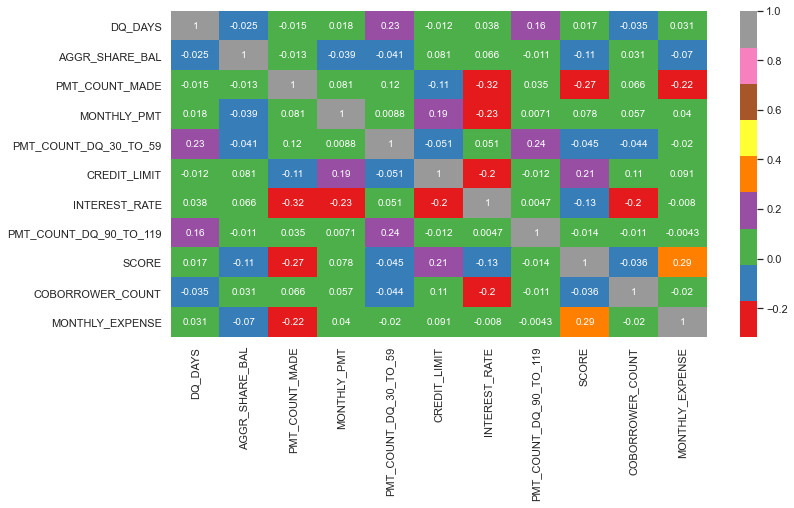

In [ ]:
cor = loan_features.corr()
plt.figure(figsize=(12,6))
sns.heatmap(cor,cmap='Set1',annot=True)

Random Forest does not require continuous value columns to be scaled or categorical columns to be one-hot encoded. It also has an embedded method of ranking the importance of features, so we will begin by running a RandomForestClassifier on the entire dataset and will then select only the most important features going forward:

In [ ]:
# Build model
rfc = RandomForestClassifier(class_weight='balanced', random_state=23)
rfc.fit(loan_features, loan_labels)

# Display scores for features and noise
print(f'{"Label":18s}: Importance')
print(26*'-')
for val, name in sorted(zip(rfc.feature_importances_, loan_features.columns), 
                        key=lambda x: x[0], reverse=True):
    print(f'{name:>18}: {100.0*val:05.2f}%')

Label             : Importance
--------------------------
           DQ_DAYS: 42.61%
    AGGR_SHARE_BAL: 13.09%
PMT_COUNT_DQ_30_TO_59: 09.31%
     INTEREST_RATE: 09.20%
       MONTHLY_PMT: 07.49%
    PMT_COUNT_MADE: 05.45%
      CREDIT_LIMIT: 04.60%
             SCORE: 04.16%
   MONTHLY_EXPENSE: 02.29%
  COBORROWER_COUNT: 01.41%
PMT_COUNT_DQ_90_TO_119: 00.39%


Out of the above features, we will try restricting our model to only using the most relevant features, which in this case we will identify as those with an importance of 1.16% or higher.

In [ ]:
#relevant_features = loan_features[['DQ_DAYS', 'AGGR_SHARE_BAL', 'INTEREST_RATE', 'PMT_COUNT_DQ_30_TO_59', 'BALANCE', 'MEMBERSHIP_DAYS', 'MONTHLY_PMT', 'AGE_IN_DAYS', \
#                                   'PMT_COUNT_MADE', 'CREDIT_LIMIT', 'AGE_OF_SCORE', 'AGGR_SHARE_COUNT', 'PMT_COUNT_DQ_60_TO_89', 'SCORE', \
#                                   'ORIGINAL_TERM_IN_MONTHS', 'DD_CHANGE', 'MONTHLY_EXPENSE', 'COBORROWER_COUNT']]
#relevant_features_train = features_train[['DQ_DAYS', 'AGGR_SHARE_BAL', 'INTEREST_RATE', 'PMT_COUNT_DQ_30_TO_59', 'BALANCE', 'MEMBERSHIP_DAYS', 'MONTHLY_PMT', 'AGE_IN_DAYS', \
#                                   'PMT_COUNT_MADE', 'CREDIT_LIMIT', 'AGE_OF_SCORE', 'AGGR_SHARE_COUNT', 'PMT_COUNT_DQ_60_TO_89', 'SCORE', \
#                                   'ORIGINAL_TERM_IN_MONTHS', 'DD_CHANGE', 'MONTHLY_EXPENSE', 'COBORROWER_COUNT']]
#relevant_features_test = features_test[['DQ_DAYS', 'AGGR_SHARE_BAL', 'INTEREST_RATE', 'PMT_COUNT_DQ_30_TO_59', 'BALANCE', 'MEMBERSHIP_DAYS', 'MONTHLY_PMT', 'AGE_IN_DAYS', \
#                                   'PMT_COUNT_MADE', 'CREDIT_LIMIT', 'AGE_OF_SCORE', 'AGGR_SHARE_COUNT', 'PMT_COUNT_DQ_60_TO_89', 'SCORE', \
#                                   'ORIGINAL_TERM_IN_MONTHS', 'DD_CHANGE', 'MONTHLY_EXPENSE', 'COBORROWER_COUNT']]
# since we already narrowed down to 11 features, just use all of them.
relevant_features = loan_features
relevant_features_train = features_train
relevant_features_test = features_test

# Create and fit scaler
relevant_ss = MinMaxScaler().fit(relevant_features_train)
relevant_features_train_ss = relevant_ss.transform(relevant_features_train)
relevant_features_test_ss = relevant_ss.transform(relevant_features_test)

We can use a heatmap to identify the level of correlation between any two of the relavent features.

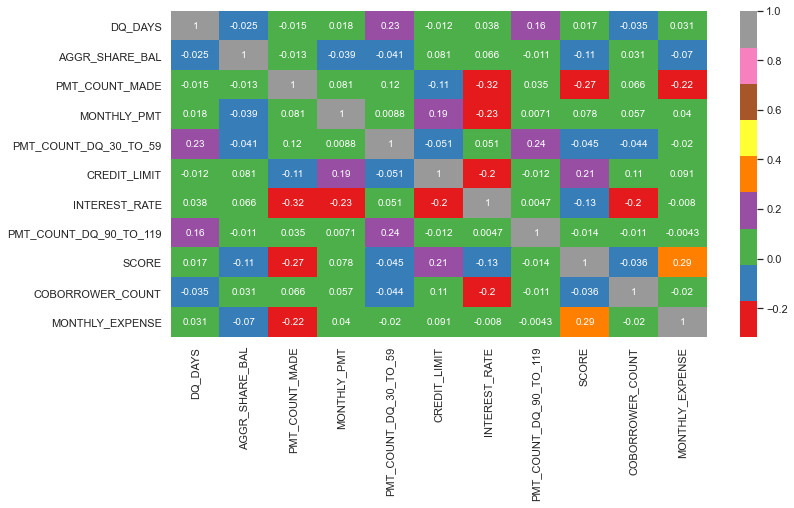

In [ ]:
cor = relevant_features.corr()
plt.figure(figsize=(12,6))
sns.heatmap(cor,cmap='Set1',annot=True)

Return to [top](#introduction)
<a id='random_forest_classifier'></a>
## Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=23) # can also use class_weight={0:0.01, 1:0.99}
# rfc.fit(relevant_features, loan_labels)

skf = StratifiedKFold(n_splits=10, random_state=23)
# accuracy score
accuracy_score = cross_val_score(rfc, relevant_features, loan_labels, cv=skf)
#positive precision
precision_score = cross_val_score(rfc, relevant_features, loan_labels, cv=skf, scoring='precision')
#positive recall
recall_score = cross_val_score(rfc, relevant_features, loan_labels, cv=skf, scoring='recall')
#auc
auc_score = cross_val_score(rfc, relevant_features, loan_labels, cv=skf, scoring='roc_auc')

print(f'Accuracy Score from Cross Validation: {np.mean(accuracy_score)*100:4.1f}%')
print(f'Positive Precision Rate from Cross Validation: {np.mean(precision_score)*100:4.1f}%')
print(f'Positive Recall Rate from Cross Validation: {np.mean(recall_score)*100:4.1f}%')
print(f'Area Under Curve from Cross Validation: {np.mean(auc_score)*100:4.1f}%')

Accuracy Score from Cross Validation: 99.5%
Positive Precision Rate from Cross Validation: 72.9%
Positive Recall Rate from Cross Validation: 34.8%
Area Under Curve from Cross Validation: 93.0%


In [ ]:
loan_labels.value_counts()

0    74786
1      485
Name: BINARY_STATUS, dtype: int64

The "zero model" would be a model that always predicts the majority case, which in this case is 0 or "loan is not in trouble". Such a model is obviously worthless as predictor, but it would have an accuracy score of 99.356%. So any model that does worse than that should not be considered. Additionally, because the dataset is heavily skewed, we need to train the model to weight the identification of positive cases more heavily. Adjusting these weights will affect not only the accuracy, but will also give us a tradeoff between high precision (reducing False Positives, aka Type 1 errors) vs. high recall (reducing False Negative, aka Type 2 errors). Our use case of identifying loans in trouble is more like a cancer screening use case than a prison conviction use case. That is, we want to lean towards high recall, even at the cost of lowering our precision somewhat.

In [ ]:
rfc = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=23)
rfc = rfc.fit(relevant_features_train, labels_train)

# Grab positive class probability
y_score_rfc = rfc.predict_proba(relevant_features_test)[:, 1]

# Compute ROC curve and ROC area
fpr_rfc, tpr_rfc, thresholds = metrics.roc_curve(labels_test, y_score_rfc)
roc_auc_rfc = metrics.auc(fpr_rfc, tpr_rfc)
print(f'AUC of Random Forest: {roc_auc_rfc:3.2f}\n\n')

AUC of Random Forest: 0.93




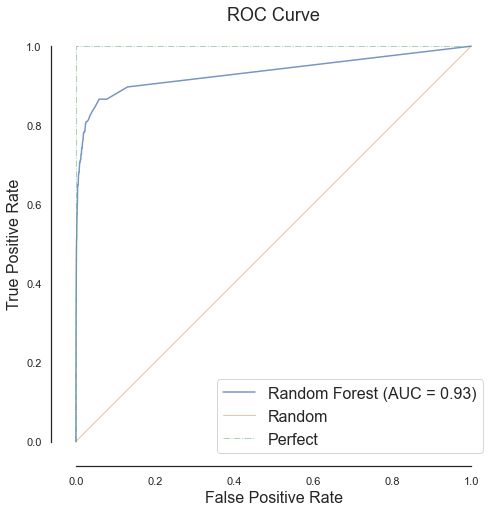

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot data and model
ax.plot(fpr_rfc, tpr_rfc, alpha = 0.75, linestyle='-',
        label=f'Random Forest (AUC = {roc_auc_rfc:4.2f})')

#plot random and perfect model ROC
ax.plot([0, 1], [0, 1], alpha = 0.5, lw=1, linestyle='-', label='Random')
ax.plot([0, 0, 1], [0, 1, 1], alpha = 0.5, lw=1, linestyle='-.', label='Perfect')

ax.set_title('ROC Curve', fontsize=18)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.set_aspect('equal')
ax.legend(loc=4, fontsize=16)
sns.despine(offset=5, trim=True)

In [ ]:
predicted_labels = rfc.predict(relevant_features_test)
accuracy_score = 100.0 * metrics.accuracy_score(labels_test, predicted_labels)
print(f'Decision Tree Classification [BINARY_STATUS] Score = {accuracy_score:4.1f}%\n')
print(f'Classification Report:\n {metrics.classification_report(labels_test, predicted_labels)}\n')

Decision Tree Classification [BINARY_STATUS] Score = 99.5%

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     29915
           1       0.79      0.32      0.46       194

    accuracy                           1.00     30109
   macro avg       0.89      0.66      0.73     30109
weighted avg       0.99      1.00      0.99     30109




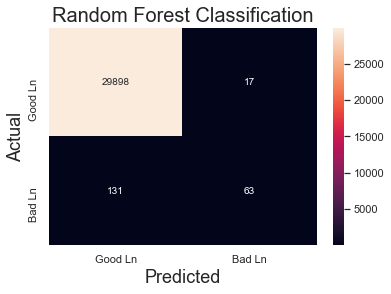

In [ ]:
# Call confusion matrix plotting routine
ml.confusion(labels_test, predicted_labels, ['Good Ln', 'Bad Ln'], title='Random Forest Classification')

Picture one of the decision trees in the random forest.

In [ ]:
#visualizing the random tree 
feature_list = list(relevant_features.columns)
#pulling out one tree from the forest
tree = rfc.estimators_[5]
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
display(Image(graph.create_png()))

Return to [top](#introduction)
<a id='k_nearest_neighbor_classifier'></a>
## K-Nearest Neighbor Classifier
Now let's try a K-Nearest Neigbor Classifier.

KNN Recall Score =  5.7%

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     29915
           1       1.00      0.06      0.11       194

    accuracy                           0.99     30109
   macro avg       1.00      0.53      0.55     30109
weighted avg       0.99      0.99      0.99     30109


Confusion Matrix:
 [[29915     0]
 [  183    11]]



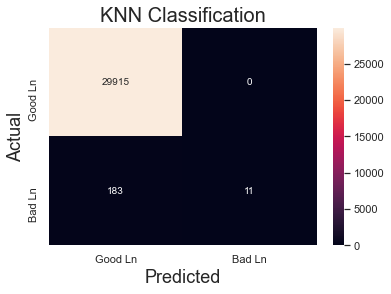

In [ ]:
knc = KNeighborsClassifier(n_neighbors=11)
knc.fit(relevant_features_train_ss, labels_train)
predicted_labels = knc.predict(relevant_features_test_ss)
recall_score = metrics.recall_score(labels_test, predicted_labels)
print(f'KNN Recall Score = {100* recall_score:4.1f}%\n')
print(f'Classification Report:\n {metrics.classification_report(labels_test, predicted_labels)}\n')
print(f'Confusion Matrix:\n {metrics.confusion_matrix(labels_test, predicted_labels)}\n')

ml.confusion(labels_test, predicted_labels, ['Good Ln', 'Bad Ln'], title='KNN Classification')

Return to [top](#introduction)
<a id='svm_classifier'></a>
## Support Vector Machine (SVM)
Now let's try a Support Vector Machine (SVM).

SVC Recall Score = 83.0%

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95     29915
           1       0.06      0.83      0.11       194

    accuracy                           0.91     30109
   macro avg       0.53      0.87      0.53     30109
weighted avg       0.99      0.91      0.95     30109




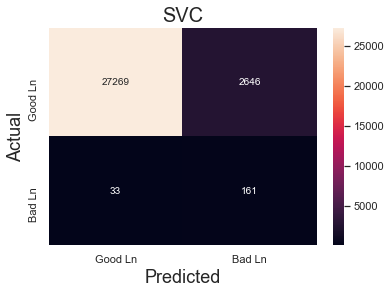

In [ ]:
#from sklearn.preprocessing import StandardScaler

# Standardize data
#sc = StandardScaler().fit(features_train)

#features_train_sc = sc.transform(features_train)
#features_test_sc = sc.transform(features_test)

from sklearn.svm import SVC

# Use default parameters, except we want a linear kernel
# and we specify the random_state hyperparameter to 
# ensure reproduceability.
svc = SVC(kernel='rbf', class_weight='balanced', random_state=23)
svc = svc.fit(relevant_features_train_ss, labels_train)

predicted_labels = svc.predict(relevant_features_test_ss)
recall_score = metrics.recall_score(labels_test, predicted_labels)
print(f'SVC Recall Score = {100* recall_score:4.1f}%\n')
print(f'Classification Report:\n {metrics.classification_report(labels_test, predicted_labels)}\n')

ml.confusion(labels_test, predicted_labels, ['Good Ln', 'Bad Ln'], title='SVC')

Return to [top](#introduction)
<a id='ann'></a>
## Deep Learning with an Artificial Neural Network (ANN)
There is a [separate notebook](TroubledLOanDetection_ANN.ipynb) that uses an ANN model to attempt "deep learning" on this data.

<a id='conclusion'></a>
## Conclusion  ##
There are several different areas of Artificial Intelligence.  The area of Machine Learning--and particularly Supervised Machine Learning using Artificial Neural Networks with multiple hidden layers (so-called "Deep Learning")--has gained a lot of traction with recent developments in computing power, algorithms, and available data.  While we can not expect to predict with 100% accuracy any given outcome based on some set of input features, it does appear based on experimentation that we can train a neural network on the loan features demonstrated above and do a good job of screening loans that should be reviewed for possible problems.  This is only <i>one</i> possible use case for machine learning, but if it can help a credit union cut their chargeoffs around 40% by identifying early loans that might benefit from some sort of proactive "wellness" program, that should be of benefit to our clients.  Ideally, the training should be done separately for each client (and even be retrained periodically per client), although for converting clients who have not been on our system long enough to acquire the required history or that are too small to build up a large enough training set, it is feasible to start with an already trained network to do the initial predictions.  However, some of the input features are based on some recent historical trends, such as changes in direct deposit amount, going from automatic payments to cash, etc., so some allowances will need to be made for any clients who have not been on the system at least six months.

<b>Recommendations for next steps (some of which can be done in parallel):</b>
- Bring John and Jeff into the loop.  Work with John to load Python 3 on our development AIX server, along with the modules we already know we will need.  Might also look into how to run a Jupyter notebook server on AIX for training and collaborating.
- Carl try to duplicate machine learning results from laptop on the AIX server.
- Find a way to survey developers on their familiarity/experience with AI/Machine Learning/Neural Networks and with Python, while making it clear the need for discretion.
- Identify one or two developers who would be good candidates for additional training in Machine Learning.  Plan and implement a curriculum with specific goals and deadlines.
- <del>Also, complete last two courses in Deep Learning specialization.  It seems unlikely to me that Convolutional Networks have any applicability, but the course on “Sequence Models” covers Recurrent Networks, and I think those might be applicable to some use cases for us, so I’d like to complete the entire series of five classes in this specialization and earn the certificate.</del>
- Brainstorm direction of Loan Analysis Bot (LAB) Assistant project: is this a periodic Professional Services engagement?  Bring a credit union in on pilot for free, and have them help us collect the data more easily by loading a backup from six months ago and another from a year ago, for example.  One possible deliverable is a combination of a SQL query of open loans, a prediction based on an already trained model, and a report of loans to review.  Naturally, these would be combined into a single batch program.  Also figure out how to market (Dwayne came up with a marketing name of KeyAssist).
- Once we have access to live data with some backups, simplify SQL queries used for learning, and do some additional work with feature engineering and looking at false negatives for “inspiration” on new features that can improve the model above the level reached during prototyping.  Note: new queries will not have as many charged off loans to use for training (only those that were charged off between backup and current database), but prediction might still be better, since not all “bad” loans will be exactly six months from being charged off.
- Brainstorm additional use cases for AI/ML, such as fraud detection, watch list screening, marketing, etc.  Look for most promising next use case based on a combination of client need, availability of data, and whether or not the solution is already essentially a commodity from established players (e.g. credit scores from the bureaus).


[Return to top of Notebook](#introduction)